In [33]:
import pandas as pd

df = pd.read_csv('LSTM_StockPrediction/daily_UNRATE_spline.csv', index_col=0)
df2= pd.read_csv('LSTM_StockPrediction/daily_UMCSENT_spline.csv', index_col=0)
df3 = pd.read_csv('sp500.csv', index_col=0)
df4 = pd.read_csv('dollar.csv', index_col=0)



In [34]:
#Conncat the two metrics 
df3['20SMA'] = df3['Close'].rolling(20).mean()
df3['5SMA'] = df3['Close'].rolling(5).mean()
df3['Lag1'] = df3['Close'].shift(1)
df3['Lag2'] = df3['Close'].shift(2)
df3['Lag3'] = df3['Close'].shift(3)

In [35]:
#Set all data frames  to all start  at 2007-02-01	
df =   df[df.index>='2007-02-01']
df2 = df2[df2.index>='2007-02-01']
df3 = df3[df3.index>='2007-02-01']
df4 = df4[df4.index>='2007-02-01']

df =   df[df.index<='2023-11-01'  ]
df2 = df2[df2.index<='2023-11-01' ]
df3 = df3[df3.index<='2023-11-01' ]
df4 = df4[df4.index<='2023-11-01' ]
  

In [36]:
df3 = df3.drop(['High','Low'],axis=1)


In [37]:
df4 = df4.drop(df4.columns[1:],axis=1)
df4 = df4.rename(columns={'Open':'Dolar'})

In [30]:
#Drop the days from the weekend from data frame
df5= pd.read_csv('LSTM_StockPrediction/daily_UNRATE_spline.csv')
df5 = df5.rename(columns={'DATE':'Date'})
df5['Date'] = pd.to_datetime(df5['Date'])
df5 = df5[df5['Date'].dt.dayofweek < 5]
df5.to_csv('LSTM_StockPrediction/daily_UNRATE_spline.csv',index=False)

#Drop the days from the weekend from data frame
df6= pd.read_csv('LSTM_StockPrediction/daily_UMCSENT_spline.csv')
df6 = df6.rename(columns={'DATE':'Date'})
df6['Date'] = pd.to_datetime(df6['Date'])
df6 = df6[df6['Date'].dt.dayofweek < 5]
df6.to_csv('LSTM_StockPrediction/daily_UMCSENT_spline.csv',index=False)

In [38]:
df5 = pd.merge(df3,pd.merge(df4, pd.merge(df2, df, left_index=True, right_index=True), left_index=True, right_index=True), left_index=True, right_index=True)


In [40]:
df5.to_csv('dataset.csv')

In [1]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

tf.keras.utils.set_random_seed(44)
warnings.filterwarnings('ignore')

In [12]:
from keras.losses import Loss

def loss_1(y, y_hat):
    correct = 0
    wrong = 0
    n = y.shape[0]
    for i in range(1,n):
        temp = y[i] - y[i-1]
        temp2 = y_hat[i] - y_hat[i-1]
        if temp>0:
            if temp2>0:
                correct+=1
            else:
                wrong+=1
        if temp<=0:
            if temp2<=0:
                correct+=1
            else:
                wrong+=1
    
    return correct/n

class CustomMSELoss(Loss):
    def __init__(self,  scaler, name='custom_mse_loss'):
        super().__init__(name=name)
        self.scaler  =  scaler
    
    def inverse_minmax_scaling(self, x):
        # Get the min and max values from the scaler
        min_val = tf.constant(self.scaler.data_min_, dtype=tf.float32)
        max_val = tf.constant(self.scaler.data_max_, dtype=tf.float32)

        # Inverse MinMax scaling operation
        x_scaled = x * (max_val - min_val) + min_val
        return x_scaled
    
    def call(self, y_true, y_pred):
        # Apply inverse MinMax scaling to y_true and y_pred
        y_true_transformed = self.inverse_minmax_scaling(y_true)
        y_pred_transformed = self.inverse_minmax_scaling(y_pred)
        
        # Compute mean squared error
        mse = tf.reduce_mean(tf.square(y_true_transformed - y_pred_transformed))
        return mse
    
class NeuralNet(tf.keras.callbacks.Callback):
    def __init__(self,validation_data):
        super(NeuralNet, self).__init__()
        self.validation_data = validation_data
        self.acc       = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        predictions = self.model.predict(x_val)
        # Calculate the absolute errors\
        acc = loss_1(y_val, predictions)
        # Find and log the  error
        self.acc.append(acc)
        print(f"Epoch {epoch + 1}, Accuracy : {acc}")

In [42]:
#Create the response and predictors variables
df = pd.read_csv('dataset.csv')
df = df.drop(['Date'],axis=1)
df = df[df.columns[:-2]]
Y , X = df[df.columns[0]].to_numpy().reshape(-1,1) , df[df.columns[1:]]

In [43]:
#Normalize data

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
Y_scaled = scaler2.fit_transform(Y)
# X_scaled = X
# Y_scaled = Y


In [44]:
#Create test and train data sets
train_size = int(X_scaled.shape[0]*0.8)

#2 years to test data
test_size = 500
validation_size = X_scaled.shape[0] - train_size - test_size

trainY, valY , testY = Y_scaled[60:train_size],Y_scaled[train_size:train_size+validation_size], Y_scaled[train_size+validation_size:]


In [45]:
#Create windows of 60 days since we are using Recurent Neural Networks
# Reshape input to be  [samples, time steps, features]
trainX = []
for i in range(60, train_size):
    trainX.append(X_scaled[i-60:i,:])
trainX = np.array(trainX)

valX = []
test = X_scaled[train_size-60:train_size+validation_size, :]
for i in range(60, validation_size+60):
    valX.append(test[i-60:i,:])

valX = np.array(valX)
testX = []
test = X_scaled[train_size+validation_size-60:, :]
for i in range(60, test_size+60):
    testX.append(test[i-60:i,:])

testX = np.array(testX)


In [46]:
print(trainX.shape[0],trainY.shape[0])
print(valX.shape[0],valY.shape[0])
print(testX.shape[0],testY.shape[0])


3314 3314
344 344
500 500


In [60]:
from keras.callbacks import EarlyStopping

error = NeuralNet(validation_data=(testX, testY))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(trainX.shape[1],trainX.shape[2])))	# 50 neurons in the first layer
model.add(LSTM(50, return_sequences = False))		# 50 neurons in the second layer "Hidden Layer"
model.add(Dense(25 ,activation=tf.keras.activations.tanh))				# 25 neurons in the third layer
model.add(Dense(1))									# 1 neuron in the output layer since the output is a single value
custom_loss = CustomMSELoss(scaler2)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=custom_loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(trainX,trainY,epochs=40, batch_size=10,validation_data=(valX,valY), callbacks=[error, early_stopping] )

Epoch 1/100
16/16 [==============================] - 0s 5ms/step loss: 28814.
Epoch 1, Accuracy : 0.468
829/829 [==============================] - 14s 15ms/step - loss: 28797.5332 - val_loss: 71502.4219
Epoch 2/100
16/16 [==============================] - 0s 5ms/step loss: 3980.
Epoch 2, Accuracy : 0.496
829/829 [==============================] - 12s 14ms/step - loss: 3985.6777 - val_loss: 141008.5156
Epoch 3/100
16/16 [==============================] - 0s 5ms/step loss: 3327.
Epoch 3, Accuracy : 0.488
829/829 [==============================] - 12s 14ms/step - loss: 3411.0779 - val_loss: 47531.9453
Epoch 4/100
16/16 [==============================] - 0s 5ms/step loss: 3062.
Epoch 4, Accuracy : 0.504
829/829 [==============================] - 12s 14ms/step - loss: 3062.2695 - val_loss: 59379.2148
Epoch 5/100
16/16 [==============================] - 0s 5ms/step loss: 2641.
Epoch 5, Accuracy : 0.496
829/829 [==============================] - 12s 14ms/step - loss: 2640.4551 - val_loss: 358

In [73]:
#Predict the price for the test set
yhat = model.predict(testX)

16/16 [==============================] - 0s 6ms/step


In [74]:
#Scaled the data back to original numbers
yhat = scaler2.inverse_transform(yhat)
testY = scaler2.inverse_transform(Y_scaled[train_size+validation_size:])

In [63]:
loss_1(testY,yhat)

0.778

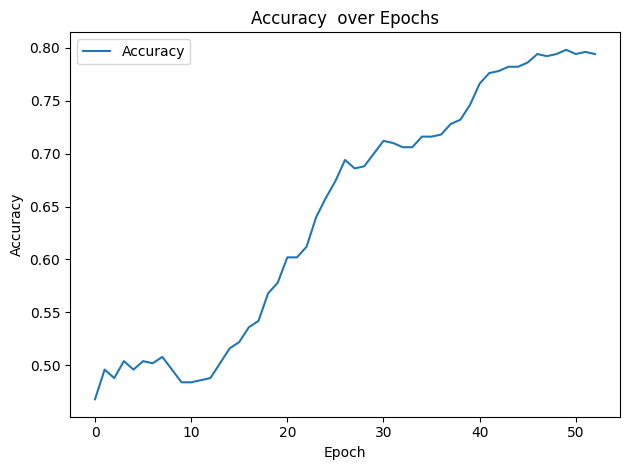

In [64]:
plt.plot(error.acc, label = 'Accuracy')
#plt.axhline(y=avg, color='blue', linestyle='--', label='Average Error')
#plt.axhline(y=maximum, color='red', linestyle='-', label='Max Error')
plt.title('Accuracy  over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()  
plt.show()

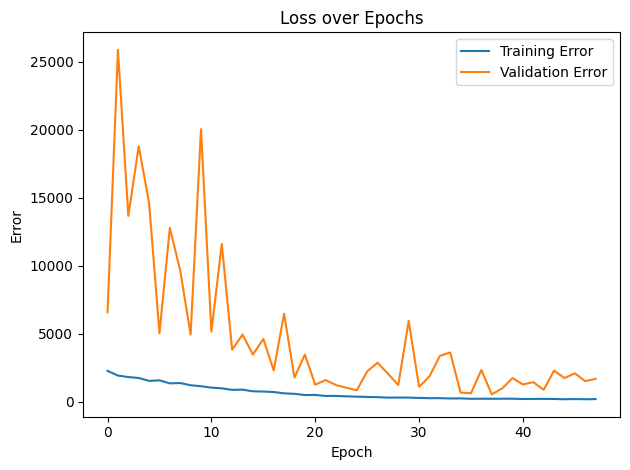

In [86]:
plt.plot(history.history['loss'][5:], label = 'Training Error')
plt.plot(history.history['val_loss'][5:], label = 'Validation Error')

#plt.axhline(y=avg, color='blue', linestyle='--', label='Average Error')
#plt.axhline(y=maximum, color='red', linestyle='-', label='Max Error')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.tight_layout()
plt.legend()  
plt.show()

In [55]:
dataX = X[X.columns[0]][60:]


In [56]:
print(yhat.shape[0],test_size )

500 500


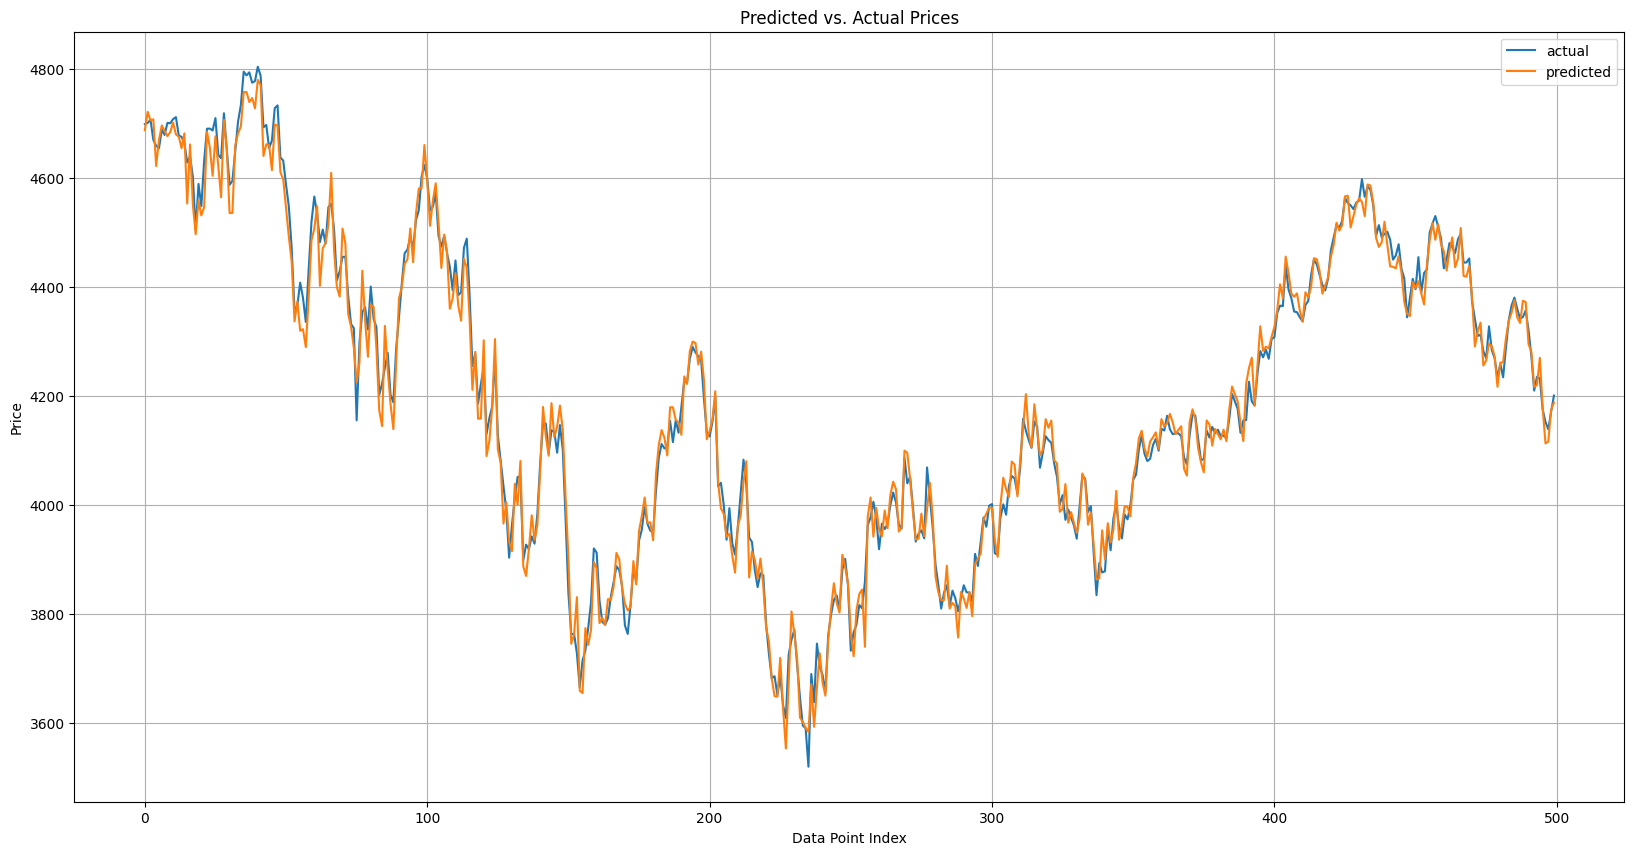

In [79]:
plt.figure(figsize=(20, 10))
plt.plot(testY, label="actual")
plt.plot( yhat , label = "predicted")

# Set plot labels and legend
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Data Point Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

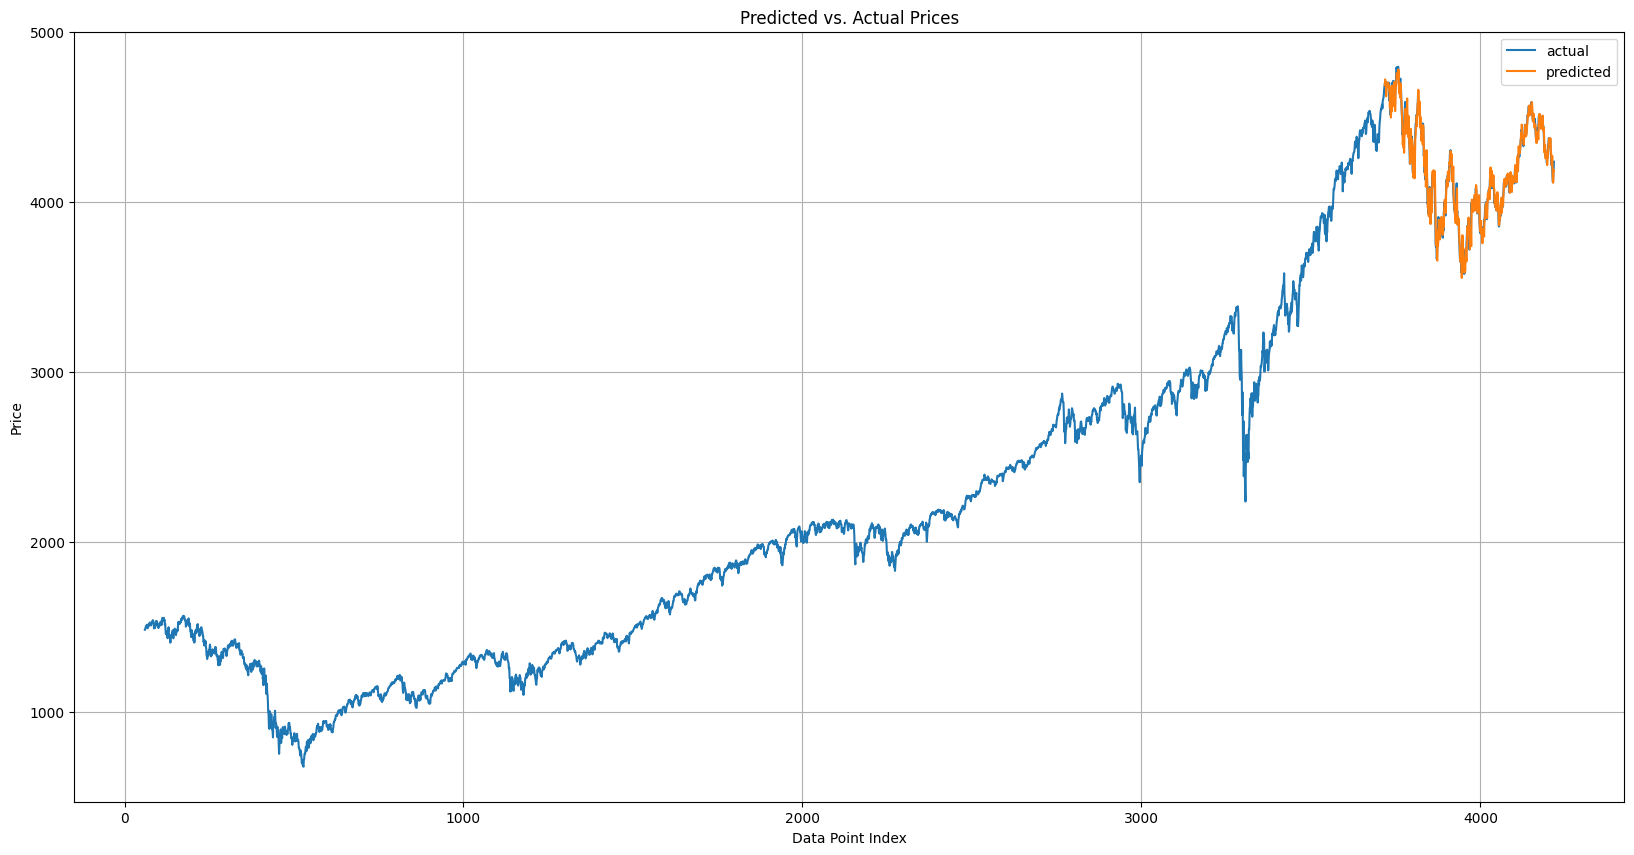

In [87]:
plt.figure(figsize=(20, 10))
plt.plot(range(60,X.shape[0]), dataX, label="actual")
plt.plot(range(train_size+validation_size, train_size+validation_size+test_size), yhat.reshape(-1,1) , label = "predicted")

# Set plot labels and legend
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Data Point Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
class Model(nn.Module):
    def __init__(self, in_features=1, hidden=64, out_features=1 ):
        super().__init__()                                      #instantiate with parent class
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden, 1)                  # hidden layer -> output
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]         #pick last element 
        x = self.linear(x)
        return x
    

def windwos(X, lookback=60):
    arr  = []
    for i in range(lookback, train_size):
        arr.append(X[i-lookback:i])
    print(arr)
    return torch.tensor(arr)

def loss_1(y, y_hat):
    correct = 0
    wrong = 0
    n = y.shape[0]
    for i in range(1,n):
        temp = y[i] - y[i-1]
        temp2 = y_hat[i] - y_hat[i-1]
        if temp>0:
            if temp2>0:
                correct+=1
            else:
                wrong+=1
        if temp<=0:
            if temp2<=0:
                correct+=1
            else:
                wrong+=1
    
    return correct/n

In [10]:
df = pd.read_csv('sp500.csv', index_col=0)
df = df[df.index>='1980-12-30']
X,Y = df[df.columns[0]].to_numpy().reshape(-1,1), df[df.columns[1]].to_numpy().reshape(-1,1)

In [11]:
#Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y)


In [26]:
#Create test and train data sets
train_size = int(X.shape[0]*0.8)
validation_size = int((X.shape[0] - train_size)*.4)
test_size = X.shape[0] - train_size - validation_size

In [40]:
X_train = windwos(X_scaled[:train_size])
X_val = windwos(X_scaled[train_size-60:train_size+validation_size])
X_test = windwos(X_scaled[train_size+validation_size:])
